# MIT Physics Dep. Data Analysis + Plotting Project

### Getting started

In [1]:
from scipy import *
from scipy.optimize import leastsq
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from math import sqrt

import seaborn as sns
sns.set_palette("colorblind")

In [2]:
#IMPORTING AND CLEANING DATA

majors = pd.read_excel("Retrospective_Data/merged_retrospective_physics_majors_studyID_2014-2022.xlsx", 
                       index_col = 0)
#majors = pd.read_excel("Retrospective_Data/physics retrospective classes 2020-22-StudyID.xlsx", 
#                       index_col = 0)

needs_cleaning = ['Physics on application', 'Physics Soph Fall', 'Physics degree']
falses = dict(zip(needs_cleaning, [False] * 3))
majors = majors.fillna(value = falses)
majors = majors.replace({'Y': True, 'N': False})
classes = np.concatenate((majors['Subj1'].unique(), majors['Subj2'].unique()))
for option in classes:
    majors = majors.replace(option, str(option).strip())


demographics = pd.read_excel("Retrospective_Data/merged_retro_demographic_data_studyid_2014-2022.xlsx", 
                             index_col = 0)
#demographics = pd.read_excel("Retrospective_Data/demos 2020-22 StudyID.xlsx", 
#                             index_col = 0)

demographics = demographics.rename(columns = {'GENDER': 'Gender', 
                                              'IPEDS_ETHNICITY': 'Ethnicity',
                                             'First Gen': 'FirstGen'})
demographics = demographics.replace({'First Gen': True, 
                                     'Yes': True,
                                     'no': False, 
                                     'No': False,
                                     'International (Not US Citizen or Perm. Resident)': 'International'})
demographics = demographics.fillna(value = False)


underrep = demographics['Ethnicity'].isin(['Hispanic or Latino',
                                           'American Indian or Alaskan Native',
                                           'Black or African American'])
demographics['Underrepresented'] = underrep


combined = majors.join(demographics)

print(combined.columns)

Index(['AppMajor', 'EntryYr', 'Soph Fall Major', 'Degree1', 'Degree1 major',
       'Degree2', 'Degree2 major', 'Degree3', 'Degree3 major', 'Subj1', 'Reg1',
       'Grade1', 'Subj2', 'Reg2', 'Grade2', 'Physics on application',
       'Physics Soph Fall', 'Physics degree', 'Ever Physics?', 'Gender',
       'Ethnicity', 'FirstGen', 'Underrepresented'],
      dtype='object')


In [3]:
#preliminary subsets and important functions

intended_all = combined.loc[combined['AppMajor'] == 'Physics']
graduated_all = combined.loc[combined['Physics degree']]
int_notgrad_all = intended_all.loc[~intended_all['Physics degree']]
grad_notint_all = graduated_all.loc[graduated_all['AppMajor'] != 'Physics']

#restructure to return dataframes
def demo_breakdown(pop, attribute): #returns a dictionary instead of a df
    result = dict()
    for choice in pop[attribute].unique():
        result[choice] = len(pop.loc[pop[attribute] == choice].index)
    return result

def overall_breakdown(pop, attribute):
    if (attribute == 'Underrepresented'): 
        pop = pop.loc[(pop['Underrepresented'] == True) |(pop['Ethnicity'] == 'White')]
    intended = pop.loc[combined['AppMajor'] == 'Physics']
    graduated = pop.loc[combined['Physics degree']]
    int_notgrad = intended.loc[~intended['Physics degree']]
    grad_notint = graduated.loc[graduated['AppMajor'] != 'Physics']
    result = pd.DataFrame(index = ['intended', 'graduated', 'grad not int', 'int not grad'],
                          columns = pop[attribute].unique())
    for choice in pop[attribute].unique():
        result.loc['intended', choice] = len(intended.loc[intended[attribute] == choice].index)
        result.loc['graduated', choice] = len(graduated.loc[graduated[attribute] == choice].index)
        result.loc['grad not int', choice] = len(grad_notint.loc[grad_notint[attribute] == choice].index)
        result.loc['int not grad', choice] = len(int_notgrad.loc[int_notgrad[attribute] == choice].index)
    return result

def dropoff_calculator(breakdown):
    result = dict()
    for attribute in breakdown.columns:
        intended = breakdown.loc['intended', attribute]
        graduated = breakdown.loc['graduated', attribute]
        if (intended != 0):
            result[attribute] = (graduated - intended) / intended
        else:
            result[attribute] = None
    return result

def dropoff_calculator2(pop, attribute):
    result = dict()
    for trait in pop[attribute].unique():
        intended = len(pop.loc[(pop[attribute] == trait) & 
                               (pop['AppMajor'] == 'Physics')].index)
        graduated = len(pop.loc[(pop[attribute] == trait) & 
                                (pop['Physics degree'])].index)
        
        if (trait == True): name = attribute
        elif (trait == False): name = 'Not ' + attribute
        else: name = trait
        
        result[name] = (graduated - intended) / intended
    return result

In [6]:
#verifying results
gender_overall_df = overall_breakdown(combined, 'Gender')
#print(gender_overall_df)
gender_dropoffs = dropoff_calculator(gender_overall_df)
#for trait in gender_dropoffs:
#    print(trait + ":\t" + str(gender_dropoffs[trait]))

fg_overall_df = overall_breakdown(combined, 'FirstGen')
fg_overall_df = fg_overall_df.rename(columns = {False: 'Other', True: 'FirstGen'})
#fg_overall_df['Other'] = fg_overall_df['Not First Gen'] + fg_overall_df['N/A']
#fg_overall_df.drop(columns = {'Not First Gen', 'N/A'}, inplace = True)
#print(fg_overall_df)
fg_dropoffs = dropoff_calculator(fg_overall_df)
#for trait in fg_dropoffs:
    #print(trait + ":\t" + str(fg_dropoffs[trait]))

under_over = combined[(combined['Underrepresented'] == True) |(combined['Ethnicity'] == 'White')]
#under_over = combined[(combined['Ethnicity'] == 'Black or African American') |(combined['Ethnicity'] == 'White')]

under_over_df = overall_breakdown(under_over, 'Underrepresented')
under_over_df = under_over_df.rename(columns = {False: 'White', True: 'Underrepresented'})
#print(under_over_df)
underover_dropoffs = dropoff_calculator(under_over_df)
#for trait in underover_dropoffs:
    #print(trait + ":\t" + str(underover_dropoffs[trait]))

In [7]:
#Forming more tables
yearly_dropoffs = pd.DataFrame(columns = ['Male', 'Female', 'FirstGen', 'Other',
                                          'Underrepresented', 'White'])
for year in range(2010, 2019):
    population = combined.loc[combined['EntryYr'] == year]
    under_over = combined.loc[(combined['EntryYr'] == year) & 
                              ((combined['Underrepresented'] == True) |
                               (combined['Ethnicity'] == 'White'))]
    gender_summary = overall_breakdown(population, 'Gender')
    fg_summary = overall_breakdown(population, 'FirstGen')
    underrep_summary = overall_breakdown(under_over, 'Underrepresented')
    
    gender_dropoff = dropoff_calculator(gender_summary)
    fg_dropoff = dropoff_calculator(fg_summary)
    underrep_dropoff = dropoff_calculator(underrep_summary)
    
    yearly_dropoffs.loc[year, 'Male'] =  gender_dropoff['Male'] * 100
    yearly_dropoffs.loc[year, 'Female'] = gender_dropoff['Female'] * 100
    yearly_dropoffs.loc[year, 'FirstGen'] = fg_dropoff[True] * 100
    yearly_dropoffs.loc[year, 'Other'] = fg_dropoff[False] * 100
    yearly_dropoffs.loc[year, 'Underrepresented'] = underrep_dropoff[True] * 100
    yearly_dropoffs.loc[year, 'White'] = underrep_dropoff[False] * 100
    
#print(yearly_dropoffs)

yearly_dropoffs_quant = pd.DataFrame(columns = ['Male', 'Female', 'FirstGen', 'Other',
                                          'Underrepresented', 'White'])
for year in range(2010, 2019):
    population = combined.loc[combined['EntryYr'] == year]
    under_over = combined.loc[(combined['EntryYr'] == year) & 
                              ((combined['Underrepresented'] == True) |
                               (combined['Ethnicity'] == 'White'))]
    gender_summary = overall_breakdown(population, 'Gender')
    fg_summary = overall_breakdown(population, 'FirstGen')
    underrep_summary = overall_breakdown(under_over, 'Underrepresented')
    
    yearly_dropoffs_quant.loc[year, 'Male'] = gender_summary.loc['intended','Male'] - gender_summary.loc['graduated','Male']
    yearly_dropoffs_quant.loc[year, 'MaleTot'] = gender_summary.loc['intended','Male']
    yearly_dropoffs_quant.loc[year, 'Female'] = gender_summary.loc['intended','Female'] - gender_summary.loc['graduated','Female']
    yearly_dropoffs_quant.loc[year, 'FemaleTot'] = gender_summary.loc['intended','Female']
    yearly_dropoffs_quant.loc[year, 'FirstGen'] = fg_summary.loc['intended',True] - fg_summary.loc['graduated',True]
    yearly_dropoffs_quant.loc[year, 'FirstGenTot'] = fg_summary.loc['intended',True]
    yearly_dropoffs_quant.loc[year, 'Other'] = fg_summary.loc['intended',False] - fg_summary.loc['graduated',False]
    yearly_dropoffs_quant.loc[year, 'OtherTot'] = fg_summary.loc['intended',False]
    yearly_dropoffs_quant.loc[year, 'Underrepresented'] = underrep_summary.loc['intended',True] - underrep_summary.loc['graduated',True]
    yearly_dropoffs_quant.loc[year, 'UnderrepresentedTot'] = underrep_summary.loc['intended',True]
    yearly_dropoffs_quant.loc[year, 'White'] = underrep_summary.loc['intended',False] - underrep_summary.loc['graduated',False]
    yearly_dropoffs_quant.loc[year, 'WhiteTot'] = underrep_summary.loc['intended',False]
    yearly_dropoffs_quant.loc[year, 'Grad Size'] = len(combined.loc[(combined['EntryYr'] == year) 
                                                        & (combined['Physics degree'])].index)
    yearly_dropoffs_quant.loc[year, 'Int Size'] = len(combined.loc[(combined['EntryYr'] == year)
                                                             & (combined['Physics on application'])].index)
    
#print(yearly_dropoffs_quant)
#print(overall_breakdown(combined.loc[(combined['EntryYr'] == 2012) & 
#                              ((combined['Underrepresented'] == True) |
#                               (combined['Ethnicity'] == 'White'))], 'Underrepresented'))
    

In [8]:
#Calculating confidence intervals
male_CI = dict()
female_CI = dict()
for year in range(2010, 2019):
    gender_break = overall_breakdown(combined.loc[combined['EntryYr'] == year], 'Gender').iloc[:2]
    m_dropoffs = gender_break.loc['intended']['Male'] - gender_break.loc['graduated']['Male']
    f_dropoffs = gender_break.loc['intended']['Female'] - gender_break.loc['graduated']['Female']
    m_CI = 1.96*sqrt(abs(m_dropoffs))/gender_break.loc['graduated']['Male']
    f_CI = 1.96*sqrt(abs(f_dropoffs))/gender_break.loc['graduated']['Female']
    male_CI[year] = m_CI
    female_CI[year] = f_CI

firstgen_CI = dict()
other_CI = dict()
for year in range(2010, 2019):
    fg_break = overall_breakdown(combined.loc[combined['EntryYr'] == year], 'FirstGen').iloc[:2]
    fg_dropoff = fg_break.loc['intended'][True] - fg_break.loc['graduated'][True]
    o_dropoffs = fg_break.loc['intended'][False] - fg_break.loc['graduated'][False]
    fg_CI = 1.96*sqrt(abs(fg_dropoff))/fg_break.loc['graduated'][True]
    o_CI = 1.96*sqrt(abs(o_dropoffs))/fg_break.loc['graduated'][False]
    firstgen_CI[year] = fg_CI
    other_CI[year] = o_CI
    
UR_CI = dict()
White_CI = dict()
for year in range(2010, 2019):
    UR_break = overall_breakdown(under_over, 'Underrepresented').iloc[:2]
    ur_dropoffs = UR_break.loc['intended'][True] - UR_break.loc['graduated'][True]
    w_dropoffs = UR_break.loc['intended'][False] - UR_break.loc['graduated'][False]
    ur_CI = 1.96*sqrt(abs(ur_dropoffs))/UR_break.loc['graduated'][True]
    w_CI = 1.96*sqrt(abs(w_dropoffs))/UR_break.loc['graduated'][False]
    UR_CI[year] = m_CI
    White_CI[year] = f_CI
    
def CI(pop, *args):
    result = dict()
    for attribute in args:
        breakdown = overall_breakdown(pop, attribute).iloc[:2]
        label1 = breakdown.columns[0]
        label2 = breakdown.columns[1]
        y1 = breakdown.loc['intended'][label1]
        x1 = breakdown.loc['graduated'][label1]
        y2 = breakdown.loc['intended'][label2]
        x2 = breakdown.loc['graduated'][label2]
        if (attribute == 'Underrepresented'):
            label1 = 'Underrepresented' if label1 else 'White'
            label2 = 'Underrepresented' if label2 else 'White'
        elif (attribute == 'FirstGen'):
            label1 = 'FirstGen' if label1 else 'Other'
            label2 = 'FirstGen' if label2 else 'Other'
        result[label1] = sqrt(x1 / (y1**2) + (x1**2) / (y1**3)) *100
        result[label2] = sqrt(x2 / (y2**2) + (x2**2) / (y2**3)) *100
    return result

yearly_CI = dict()
for y in range(2010, 2019):
    CI_all = CI(combined.loc[combined['EntryYr'] == y], 
                'Gender', 
                'FirstGen', 
                'Underrepresented')
    yearly_CI[y] = CI_all
        

### Time to plot!

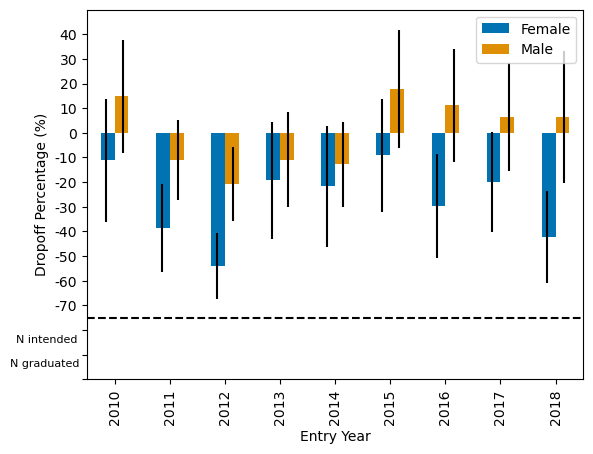

In [9]:
#Female Students
rangemax = max(yearly_dropoffs['Male'].max(), yearly_dropoffs['Female'].max())
rangemin = min(yearly_dropoffs['Male'].min(), yearly_dropoffs['Female'].min())

yrange = (round(rangemin, -1) - 50, round(rangemax, -1) + 30)
yticks = np.arange(yrange[0], yrange[1], 10, dtype=int)
ytickslabels = yticks.tolist()
for i in range(len(ytickslabels)): 
    if (ytickslabels[i] <= round(rangemin, -1) - 30): ytickslabels[i] = ''

gender_bars = yearly_dropoffs.plot.bar(y = ['Female', 'Male'],
                                       xlabel = 'Entry Year', ylabel = 'Dropoff Percentage (%)', 
                                       ylim=yrange)

plt.yticks(ticks=yticks,
           labels=ytickslabels)


intlocation = yrange[0] + 15
gradlocation = yrange[0] + 5
plt.text(x=-1.8, y=intlocation, s="N intended", size=8)
plt.text(x=-1.9, y=gradlocation, s="N graduated", size=8)
plt.axhline(yrange[0] + 25, linestyle='--', color='black')


for year in range(2010, 2019):
    plt.errorbar(x = year - 2009.85, y = yearly_dropoffs.loc[year]['Male'], 
                 yerr = yearly_CI[year]['Male'], color='black')
    plt.errorbar(x = year - 2010.15, y = yearly_dropoffs.loc[year]['Female'], 
                 yerr = yearly_CI[year]['Female'], color='black')
    
    intended_male = yearly_dropoffs_quant.loc[year, 'MaleTot'] + yearly_dropoffs_quant.loc[year, 'Male']
    intended_female = yearly_dropoffs_quant.loc[year, 'FemaleTot'] + yearly_dropoffs_quant.loc[year, 'Female']
    
    #plt.text(x =year - 2010.3, y =intlocation, s=str(int(intended_male)), size=8, color='#377eb8')
    #plt.text(x=year - 2010.3, y=gradlocation, s=str(int(yearly_dropoffs_quant.loc[year, 'MaleTot'])), size=8, color='#377eb8')
    
    #plt.text(x = year - 2010, y=intlocation, s =str(int(intended_female)), size = 8, color ='#ff7f00')
    #plt.text(x=year - 2010, y=gradlocation, s=str(int(yearly_dropoffs_quant.loc[year, 'FemaleTot'])), size=8, color='#ff7f00')
    #display the numerator (dropoffs) and denominator (grads). use new formula

#10/2/23 do ethnicity chart (try toying w/ diff. races). have overall 9 year summaries for each demo. 
#4 numbers on top of each other, no slash, brainstorm labels to delineate intended vs graduated (perhaps 'row' labels)
#get rid of floating points, label ("Gender"), grad class size
#LABEL Y AXIS ("Dropoff Percentage", "N_grad - N_int / N_int"), adjust ticks to percentages
#use color-blind friendly colors

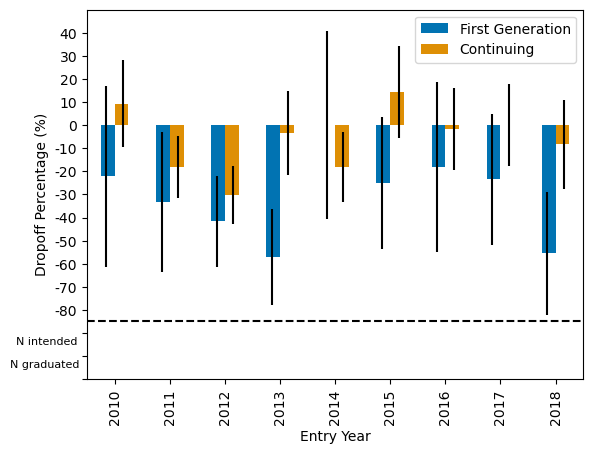

In [10]:
#FirstGen Students
rangemax = max(yearly_dropoffs['FirstGen'].max(), yearly_dropoffs['Other'].max())
rangemin = min(yearly_dropoffs['FirstGen'].min(), yearly_dropoffs['Other'].min())

yrange = (round(rangemin, -1) - 50, round(rangemax, -1) + 40)
yticks = np.arange(yrange[0], yrange[1], 10, dtype=int)
ytickslabels = yticks.tolist()
for i in range(len(ytickslabels)): 
    if (ytickslabels[i] <= round(rangemin, -1) - 30): ytickslabels[i] = ''


fli_bars = yearly_dropoffs.plot.bar(y=['FirstGen', 'Other'],
                                    xlabel='Entry Year', ylabel='Dropoff Percentage (%)', ylim=yrange)
plt.yticks(ticks=yticks, labels=ytickslabels)
plt.legend(['First Generation', 'Continuing'])


intlocation = yrange[0] + 15
gradlocation = yrange[0] + 5
plt.text(x=-1.8, y=intlocation, s="N intended", size=8)
plt.text(x=-1.9, y=gradlocation, s="N graduated", size=8)
plt.axhline(yrange[0] + 25, linestyle='--', color='black')

for year in range(2010, 2019):
    plt.errorbar(x = year - 2010.15, y = yearly_dropoffs.loc[year]['FirstGen'], 
                 yerr = yearly_CI[year]['FirstGen'], color='black')
    plt.errorbar(x = year - 2009.85, y = yearly_dropoffs.loc[year]['Other'], 
                 yerr = yearly_CI[year]['Other'], color='black')
    
    intended_fg = yearly_dropoffs_quant.loc[year, 'FirstGen'] + yearly_dropoffs_quant.loc[year, 'FirstGenTot']
    intended_o = yearly_dropoffs_quant.loc[year, 'Other'] + yearly_dropoffs_quant.loc[year, 'OtherTot']
    
    #plt.text(x = year - 2010.3, y=intlocation, s =str(int(intended_fg)), size = 8, color ='#377eb8')
    #plt.text(x=year - 2010.3, y=gradlocation, s=str(int(yearly_dropoffs_quant.loc[year, 'FirstGenTot'])), size=8, color='#377eb8')
    
    #plt.text(x = year - 2010, y=intlocation, s =str(int(intended_o)), size = 8, color ='#ff7f00')
    #plt.text(x=year - 2010, y=gradlocation, s=str(int(yearly_dropoffs_quant.loc[year, 'OtherTot'])), size=8, color='#ff7f00')

#FirstGen should formally be First-Generation
#Convertt Other to Continuing - i.e other should only include "no" and not "N/A"

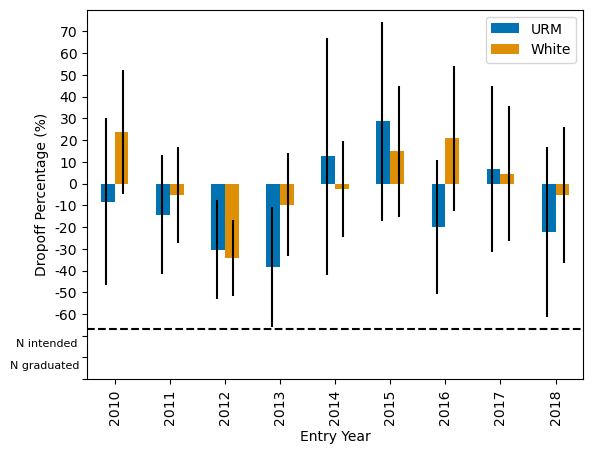

In [11]:
#URM Students
rangemax = max(yearly_dropoffs['Underrepresented'].max(), yearly_dropoffs['White'].max())
rangemin = min(yearly_dropoffs['Underrepresented'].min(), yearly_dropoffs['White'].min())

yrange = (round(rangemin, -1) - 50, round(rangemax, -1) + 50)
yticks = np.arange(yrange[0], yrange[1], 10, dtype=int)
ytickslabels = yticks.tolist()
for i in range(len(ytickslabels)): 
    if (ytickslabels[i] <= round(rangemin, -1) - 30): ytickslabels[i] = ''

ethnicity_bars = yearly_dropoffs.plot.bar(y = ['Underrepresented', 'White'],
                                    xlabel = 'Entry Year', ylabel='Dropoff Percentage (%)', ylim=yrange)
plt.yticks(ticks=yticks, labels=ytickslabels)
plt.legend(['URM', 'White'])

intlocation = yrange[0] + 15
gradlocation = yrange[0] + 5
plt.text(x=-1.8, y=intlocation, s="N intended", size=8)
plt.text(x=-1.9, y=gradlocation, s="N graduated", size=8)
plt.axhline(yrange[0] + 23, linestyle='--', color='black')

for year in range(2010, 2019):
    intended_ur = yearly_dropoffs_quant.loc[year, 'Underrepresented'] + yearly_dropoffs_quant.loc[year, 'UnderrepresentedTot']
    intended_w = yearly_dropoffs_quant.loc[year, 'White'] + yearly_dropoffs_quant.loc[year, 'WhiteTot']
    
    #plt.text(x =year - 2010.3, y=intlocation, s =str(int(intended_ur)), size = 8, color ='#377eb8')
    #plt.text(x=year - 2010.3, y=gradlocation, s=str(int(yearly_dropoffs_quant.loc[year, 'UnderrepresentedTot'])), size=8, color='#377eb8')
    
    #plt.text(x = year - 2010, y=intlocation, s =str(int(intended_w)), size = 8, color ='#ff7f00')
    #plt.text(x=year - 2010, y=gradlocation, s=str(int(yearly_dropoffs_quant.loc[year, 'WhiteTot'])), size=8, color='#ff7f00')
    
    plt.errorbar(x = year - 2010.15, y = yearly_dropoffs.loc[year]['Underrepresented'], 
                 yerr = yearly_CI[year]['Underrepresented'], color='black')
    plt.errorbar(x = year - 2009.85, y = yearly_dropoffs.loc[year]['White'], 
                 yerr = yearly_CI[year]['White'], color='black')
    #fix rainbows
#replace "underrepresented" w/ URM in legend
#11/13/23 remove bottom two ticks, add dotted line to distinguish

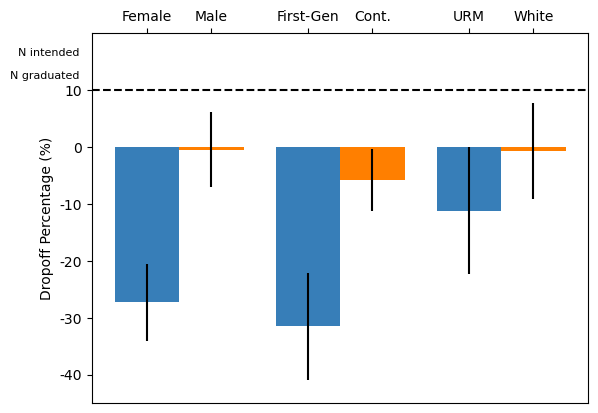

In [13]:
categories = ['Gender', 'First Generation', 'Ethnicity']

cumulative_dropoff = gender_dropoffs| fg_dropoffs | underover_dropoffs
#print(cumulative_dropoff)

CI_overall = CI(combined, 'Gender', 'FirstGen', 'Underrepresented')

barwidth = 0.4
control = ['Male', 'Other', 'White']
case = ['Female', 'FirstGen', 'Underrepresented']
control_group = [cumulative_dropoff[control[0]]*100, cumulative_dropoff[control[1]]*100, cumulative_dropoff[control[2]]*100]
control_CI = [CI_overall[control[0]], CI_overall[control[1]], CI_overall[control[2]]]

case_group = [cumulative_dropoff[case[0]]*100, cumulative_dropoff[case[1]]*100, cumulative_dropoff[case[2]]*100]
case_CI = [CI_overall[case[0]], CI_overall[case[1]], CI_overall[case[2]]]

plt.bar(np.arange(3) + barwidth, control_group, width = barwidth, yerr=control_CI, color='#ff7f00')
plt.bar(np.arange(3), case_group, width = barwidth, yerr=case_CI, color='#377eb8')

ymax = max(max(control_group), max(case_group))
ymin = min(min(control_group), min(case_group))
yrange = (round(ymin, -1) - 15, round(ymax, -1) + 20)
yticks = np.arange(round(yrange[0], -1), yrange[1], 10, dtype=int)
ytickslabels = yticks.tolist()


plt.ylim(yrange)
plt.ylabel("Dropoff Percentage (%)")
plt.xticks(np.concatenate((np.arange(3), np.arange(barwidth, 3))), ('Female', 'First-Gen', 'URM', 'Male', 'Cont.', 'White'))
plt.yticks(ticks=yticks, labels=ytickslabels)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

intlocation = round(ymax, -1) + 16
gradlocation = round(ymax, -1) + 12
plt.text(x=-0.8, y=intlocation, s="N intended", size=8)
plt.text(x=-0.85, y=gradlocation, s="N graduated", size=8)
plt.axhline(10, linestyle='--', color='black')

case_intended = (str(gender_overall_df.loc['intended', 'Female']), str(fg_overall_df.loc['intended', 'FirstGen']), 
                 str(under_over_df.loc['intended', 'Underrepresented']))
control_intended = (str(gender_overall_df.loc['intended', 'Male']), str(fg_overall_df.loc['intended', 'Other']), 
                 str(under_over_df.loc['intended', 'White']))
case_graduated = (str(gender_overall_df.loc['graduated', 'Female']), str(fg_overall_df.loc['graduated', 'FirstGen']), 
                 str(under_over_df.loc['graduated', 'Underrepresented']))
control_graduated = (str(gender_overall_df.loc['graduated', 'Male']), str(fg_overall_df.loc['graduated', 'Other']), 
                 str(under_over_df.loc['graduated', 'White']))
#for x in np.arange(3):
    #plt.text(x, intlocation, case_intended[x], color='#377eb8')
    #plt.text(x+barwidth, intlocation, control_intended[x], color='#ff7f00')
    #plt.text(x, gradlocation, case_graduated[x], color='#377eb8')
    #plt.text(x+barwidth, gradlocation, control_graduated[x], color='#ff7f00')

plt.show()

### side quest: What majors are physics students switching to?

In [191]:
female_dropoffs = combined.loc[(combined['Gender'] == 'Female') & 
                               (combined['AppMajor'] == 'Physics') & 
                               (combined['Physics degree'] == False)]
male_dropoffs = combined.loc[(combined['Gender'] == 'Male') & 
                               (combined['AppMajor'] == 'Physics') & 
                               (combined['Physics degree'] == False)]
female_switch = pd.DataFrame()
for major in female_dropoffs['Degree1 major'].unique():
    female_switch.loc[major, 'Count'] = len(female_dropoffs.loc[female_dropoffs['Degree1 major'] == major].index)
    
male_switch = pd.DataFrame()
for major in male_dropoffs['Degree1 major'].unique():
    male_switch.loc[major, 'Count'] = len(male_dropoffs.loc[male_dropoffs['Degree1 major'] == major].index)
print(female_switch.sort_values(by='Count', ascending=False).head())
print(male_switch.sort_values(by='Count', ascending=False).head())


    Count
6    51.0
2    22.0
18   16.0
16   13.0
1     9.0
    Count
6   122.0
18   33.0
2    26.0
16   19.0
22    7.0
White: 278
International: 92
Hispanic or Latino: 93
Black or African American: 25
Asian: 116
Race/Ethnicity Unknown: 13
Two or more races: 40
American Indian or Alaskan Native: 1
Native Hawaiian or Other Pacific Islander: 0
658


### Answer: Computer Science (6) !